<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [13]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    import data_setup, engine
except:
    print("[INFO] Couldn't find going_modular scripts")


In [14]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [15]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


### Prepare data

In [16]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2938994ffd0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [8]:
# Setup the model with pretrained weights and send it to the target device 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)
#model_0 # uncomment to output (it's very long)

In [9]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [10]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [12]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:14<00:56, 14.14s/it]

Epoch: 1 | train_loss: 1.0986 | train_acc: 0.4258 | test_loss: 0.9220 | test_acc: 0.5085


 40%|████      | 2/5 [00:30<00:45, 15.28s/it]

Epoch: 2 | train_loss: 0.8702 | train_acc: 0.7578 | test_loss: 0.8034 | test_acc: 0.7434


 60%|██████    | 3/5 [00:46<00:31, 15.59s/it]

Epoch: 3 | train_loss: 0.7824 | train_acc: 0.7734 | test_loss: 0.7425 | test_acc: 0.7737


 80%|████████  | 4/5 [01:01<00:15, 15.49s/it]

Epoch: 4 | train_loss: 0.7299 | train_acc: 0.7422 | test_loss: 0.6499 | test_acc: 0.8968


100%|██████████| 5/5 [01:16<00:00, 15.33s/it]

Epoch: 5 | train_loss: 0.6383 | train_acc: 0.7812 | test_loss: 0.6265 | test_acc: 0.9072
[INFO] Total training time: 76.677 seconds


### Make predictions on the entire test dataset with the model

In [ ]:
# TODO

test_loss, test_acc = engine.test_step(
    model=model_0,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    device=device
)  


In [68]:
all_preds = []
all_labels = []
all_probs = []
all_images = []

model_0.eval()
with torch.inference_mode():
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_preds = model_0(X_batch)

        y_probs = torch.softmax(y_preds, dim=1)

        y_pred_class = torch.argmax(y_probs, dim=1)

        all_preds.append(y_pred_class.cpu())
        all_labels.append(y_batch.cpu())
        all_probs.append(y_probs.cpu())
        all_images.append(X_batch.cpu())

all_preds_tensor = torch.cat(all_preds)
all_labels_tensor = torch.cat(all_labels)
all_probs_tensor = torch.cat(all_probs)
all_images_tensor = torch.cat(all_images)


### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [18]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    %pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [19]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [69]:
# TODO
from torchmetrics.classification import ConfusionMatrix

confmat = ConfusionMatrix(task="multiclass", num_classes= len(class_names))
conf_matrix = confmat(all_preds_tensor.to("cpu"), all_labels_tensor.to("cpu"))



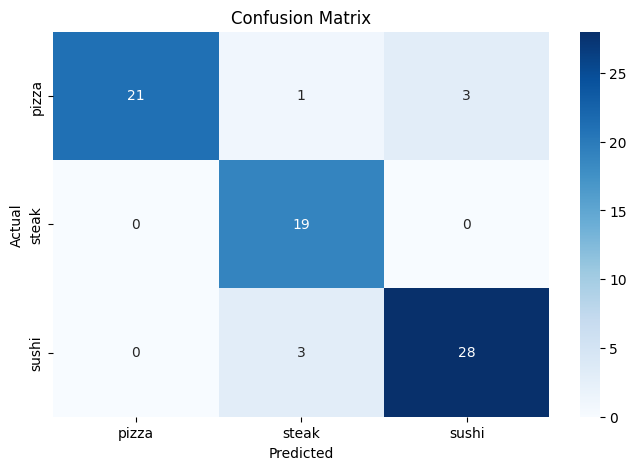

In [70]:
#LET'S VISUALIZE!!
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix.numpy(), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [71]:
#CALCULATING OTHER METRICS
from torchmetrics import Accuracy, Precision, Recall, F1Score

all_preds_tensor, all_labels_tensor = all_preds_tensor.to("cpu"), all_labels_tensor.to("cpu")

accuracy = Accuracy(task="multiclass", num_classes=len(class_names))
precision = Precision(task="multiclass", num_classes=len(class_names) ,average="macro")
recall = Recall(task="multiclass", num_classes=len(class_names),average="macro")
f1 = F1Score(task="multiclass", num_classes=len(class_names),average="macro")

acc_val = accuracy(all_preds_tensor, all_labels_tensor)
precision_val = precision(all_preds_tensor, all_labels_tensor)
recall_val= recall(all_preds_tensor, all_labels_tensor)
f1_val= f1(all_preds_tensor, all_labels_tensor)

print(f"Accuracy: {acc_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")

Accuracy: 0.9067
Precision: 0.9098
Recall: 0.9144
F1 Score: 0.9070


## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [73]:
# TODO
import pandas as pd

top_probs, top_classes = torch.max(all_probs_tensor, dim=1)
is_correct = top_classes == all_labels_tensor

df_results = pd.DataFrame({
    "pred_label" : top_classes.numpy(),
    "true_label" : all_labels_tensor.numpy(),
    "pred_probs" : top_probs.numpy(),
    "is_correct" : is_correct.numpy()
})


most_wrong = df_results[df_results["is_correct"] == False]
most_wrong_sorted = most_wrong.sort_values(by="pred_probs", ascending=False).head()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


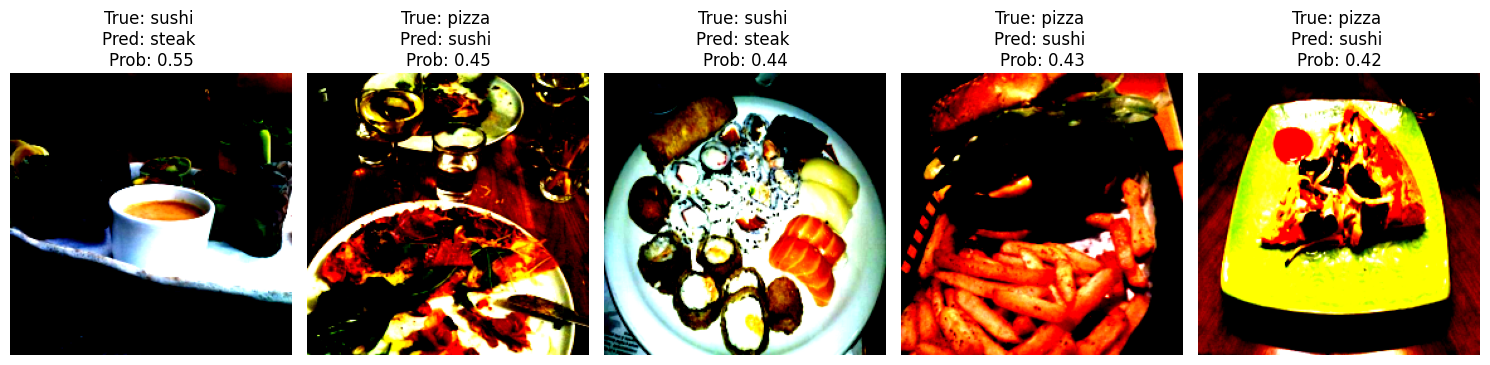

In [79]:
plt.figure(figsize=(15,8))
for idx, row in enumerate(most_wrong_sorted.itertuples()):
    img = all_images_tensor[row.Index]
    img = img.permute(1,2,0)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {class_names[row.true_label]} \nPred: {class_names[row.pred_label]} \nProb: {row.pred_probs:.2f}")
plt.tight_layout()
plt.show()

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


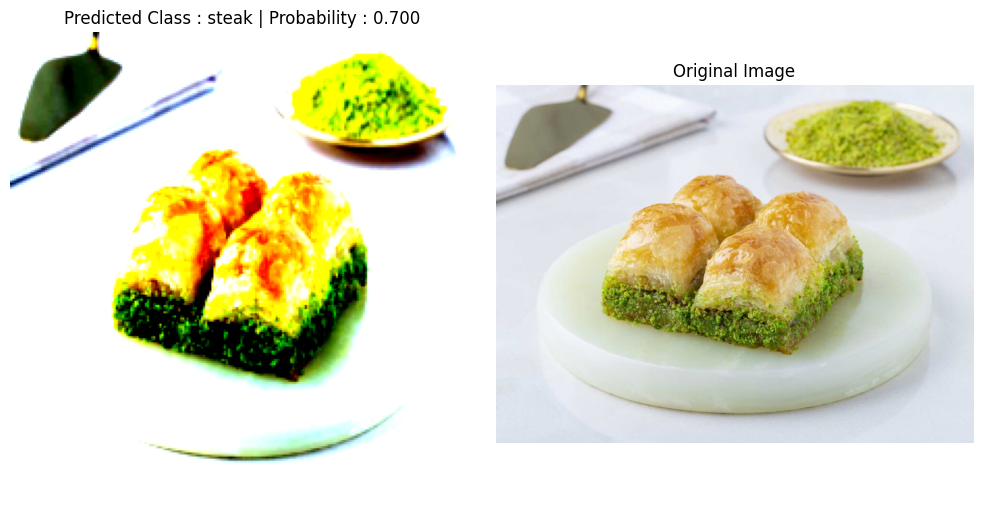

In [61]:
# TODO: Get an image of not pizza/steak/sushi
from typing import List
import PIL.Image

def plot_my_own_img(
        img_path: str,
        class_names: List[str] = class_names,
        transform: transforms.Compose = simple_transform,
        model: torch.nn.Module = model_0,
        device: torch.device = device,
        
):
    img = PIL.Image.open(img_path)
    img_transformed = transform(img)
    img_permuted =img_transformed.permute(1,2,0)
    img_transformed = img_transformed.unsqueeze(dim=0).to(device)#ADD BATCH

    img_pred_logits = model(img_transformed)
    img_pred_probs = torch.softmax(img_pred_logits, dim=1)
    img_pred_label = torch.argmax(img_pred_probs, dim=1)


    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title(f"Predicted Class : {class_names[img_pred_label.item()]} | Probability : {img_pred_probs.max().item():.3f}")
    plt.axis("off")
    plt.imshow(img_permuted)

    plt.subplot(1,2,2)
    plt.title("Original Image")
    plt.axis("off")
    plt.imshow(img)

    plt.tight_layout()
    plt.show()

plot_my_own_img(img_path= data_path / "baklava.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


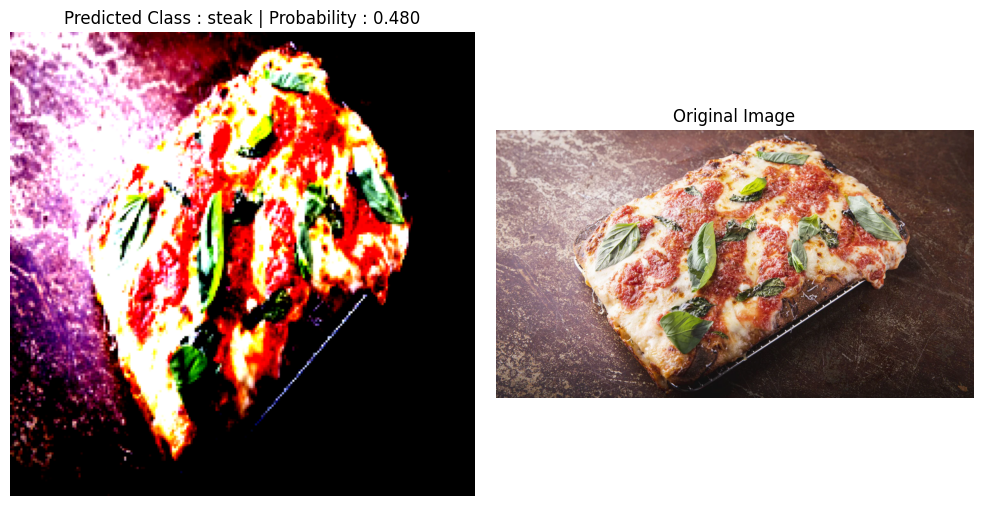

In [63]:
# TODO: Get an image of not pizza/steak/sushi
from typing import List
import PIL.Image

def plot_my_own_img(
        img_path: str,
        class_names: List[str] = class_names,
        transform: transforms.Compose = simple_transform,
        model: torch.nn.Module = model_0,
        device: torch.device = device,
        
):
    img = PIL.Image.open(img_path)
    img_transformed = transform(img)
    img_permuted =img_transformed.permute(1,2,0)
    img_transformed = img_transformed.unsqueeze(dim=0).to(device)#ADD BATCH

    img_pred_logits = model(img_transformed)
    img_pred_probs = torch.softmax(img_pred_logits, dim=1)
    img_pred_label = torch.argmax(img_pred_probs, dim=1)


    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title(f"Predicted Class : {class_names[img_pred_label.item()]} | Probability : {img_pred_probs.max().item():.3f}")
    plt.axis("off")
    plt.imshow(img_permuted)

    plt.subplot(1,2,2)
    plt.title("Original Image")
    plt.axis("off")
    plt.imshow(img)

    plt.tight_layout()
    plt.show()

plot_my_own_img(img_path= data_path / "sicilian_pizza.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


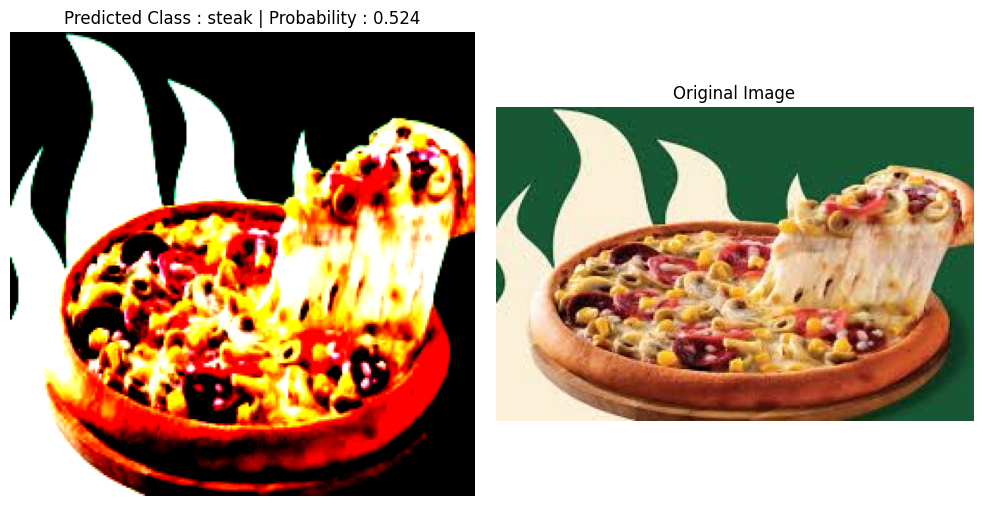

In [64]:
plot_my_own_img(data_path / "pizza2.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


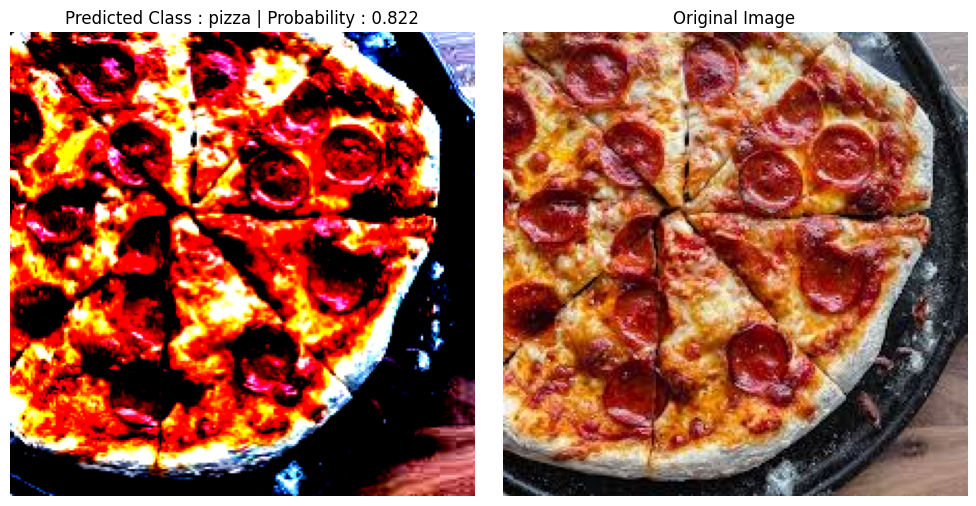

In [65]:
plot_my_own_img(data_path / "pizza3.jpg")

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [83]:
# TODO: Recreate a new model
from torchinfo import summary
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights)

model_1_summary = summary(model_1, input_size=(32,3,224,224))
summary

<function torchinfo.torchinfo.summary(model: 'nn.Module', input_size: 'INPUT_SIZE_TYPE | None' = None, input_data: 'INPUT_DATA_TYPE | None' = None, batch_dim: 'int | None' = None, cache_forward_pass: 'bool | None' = None, col_names: 'Iterable[str] | None' = None, col_width: 'int' = 25, depth: 'int' = 3, device: 'torch.device | str | None' = None, dtypes: 'list[torch.dtype] | None' = None, mode: 'str | None' = None, row_settings: 'Iterable[str] | None' = None, verbose: 'int | None' = None, **kwargs: 'Any') -> 'ModelStatistics'>

In [92]:
#FREEZE THE LAYERS

for param in model_1.features.parameters():
    param.requires_grad = False

def summarize_model(model: torch.nn.Module):
    model_summary = summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
    print(model_summary)

summarize_model(model=model_1)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [86]:
# TODO: Train the model for 10 epochs
from timeit import default_timer as Timer
from engine import train

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.003)

torch.manual_seed(57)
torch.cuda.manual_seed(57)

start_time = Timer()

resuts = train(
    model=model_1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=10,
    device=device
)

end_time = Timer()
print(f"[INFO] Total running time: {end_time-start_time:.3f} seconds")


 10%|█         | 1/10 [00:14<02:06, 14.09s/it]

Epoch: 1 | train_loss: 4.4185 | train_acc: 0.2344 | test_loss: 2.6490 | test_acc: 0.1970


 20%|██        | 2/10 [00:28<01:53, 14.24s/it]

Epoch: 2 | train_loss: 1.5998 | train_acc: 0.3672 | test_loss: 1.2962 | test_acc: 0.4763


 30%|███       | 3/10 [00:42<01:40, 14.35s/it]

Epoch: 3 | train_loss: 1.0596 | train_acc: 0.5312 | test_loss: 1.2161 | test_acc: 0.4773


 40%|████      | 4/10 [01:00<01:33, 15.52s/it]

Epoch: 4 | train_loss: 0.8889 | train_acc: 0.6328 | test_loss: 0.9589 | test_acc: 0.7225


 50%|█████     | 5/10 [01:21<01:28, 17.74s/it]

Epoch: 5 | train_loss: 0.6994 | train_acc: 0.7148 | test_loss: 0.8464 | test_acc: 0.7936


 60%|██████    | 6/10 [01:45<01:19, 19.85s/it]

Epoch: 6 | train_loss: 0.5658 | train_acc: 0.7383 | test_loss: 0.6443 | test_acc: 0.8873


 70%|███████   | 7/10 [02:06<00:59, 19.96s/it]

Epoch: 7 | train_loss: 0.5796 | train_acc: 0.7500 | test_loss: 0.7078 | test_acc: 0.8049


 80%|████████  | 8/10 [02:25<00:39, 19.79s/it]

Epoch: 8 | train_loss: 0.5606 | train_acc: 0.7891 | test_loss: 0.7243 | test_acc: 0.8466


 90%|█████████ | 9/10 [02:43<00:19, 19.39s/it]

Epoch: 9 | train_loss: 0.5187 | train_acc: 0.7734 | test_loss: 0.6431 | test_acc: 0.9186


100%|██████████| 10/10 [03:01<00:00, 18.18s/it]

Epoch: 10 | train_loss: 0.5274 | train_acc: 0.7617 | test_loss: 0.7390 | test_acc: 0.8153
[INFO] Total running time: 181.776 seconds


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [87]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [88]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [89]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2944c4d7450>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [90]:
# TODO
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights)

summary(model_2)


Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

### Train a model with 20% of the data

In [91]:
# TODO

#FIRST FREEZE THE LAYERS
for param in model_2.features.parameters():
    param.requires_grad = False


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.003)

train(model=model_2,
      train_dataloader=train_dataloader_20_percent,
      test_dataloader=test_dataloader_20_percent,
      optimizer=optimizer,
      loss_fn=criterion,
      epochs=10,
      device=device
      )


 10%|█         | 1/10 [00:15<02:15, 15.00s/it]

Epoch: 1 | train_loss: 3.2730 | train_acc: 0.3021 | test_loss: 1.2569 | test_acc: 0.5250


 20%|██        | 2/10 [00:29<01:58, 14.80s/it]

Epoch: 2 | train_loss: 0.9898 | train_acc: 0.6208 | test_loss: 0.6252 | test_acc: 0.7858


 30%|███       | 3/10 [00:44<01:43, 14.82s/it]

Epoch: 3 | train_loss: 0.5928 | train_acc: 0.8208 | test_loss: 0.4915 | test_acc: 0.8477


 40%|████      | 4/10 [01:01<01:33, 15.56s/it]

Epoch: 4 | train_loss: 0.4600 | train_acc: 0.8583 | test_loss: 0.4014 | test_acc: 0.8636


 50%|█████     | 5/10 [01:19<01:22, 16.54s/it]

Epoch: 5 | train_loss: 0.3800 | train_acc: 0.9083 | test_loss: 0.3703 | test_acc: 0.8636


 60%|██████    | 6/10 [01:38<01:09, 17.35s/it]

Epoch: 6 | train_loss: 0.3862 | train_acc: 0.8250 | test_loss: 0.3454 | test_acc: 0.8972


 70%|███████   | 7/10 [01:57<00:53, 17.98s/it]

Epoch: 7 | train_loss: 0.3068 | train_acc: 0.9042 | test_loss: 0.3348 | test_acc: 0.9102


 80%|████████  | 8/10 [02:18<00:37, 18.89s/it]

Epoch: 8 | train_loss: 0.2806 | train_acc: 0.9187 | test_loss: 0.2813 | test_acc: 0.9193


 90%|█████████ | 9/10 [02:40<00:19, 19.78s/it]

Epoch: 9 | train_loss: 0.2561 | train_acc: 0.9292 | test_loss: 0.3132 | test_acc: 0.8977


100%|██████████| 10/10 [03:00<00:00, 18.02s/it]

Epoch: 10 | train_loss: 0.2675 | train_acc: 0.9313 | test_loss: 0.3458 | test_acc: 0.8790


{'train_loss': [3.2730050086975098,
  0.9898261586825053,
  0.5928216685851415,
  0.4599992593129476,
  0.3799761285384496,
  0.38615559140841166,
  0.30677886108557384,
  0.28062614699204763,
  0.2560535987218221,
  0.2675284117460251],
 'train_acc': [0.3020833333333333,
  0.6208333333333333,
  0.8208333333333333,
  0.8583333333333333,
  0.9083333333333333,
  0.825,
  0.9041666666666667,
  0.91875,
  0.9291666666666667,
  0.93125],
 'test_loss': [1.2568533301353455,
  0.6251795649528503,
  0.49150789380073545,
  0.4014485597610474,
  0.3703224301338196,
  0.3454039990901947,
  0.33481903076171876,
  0.2813078731298447,
  0.3132317245006561,
  0.3457732111215591],
 'test_acc': [0.525,
  0.7857954545454545,
  0.8477272727272727,
  0.8636363636363636,
  0.8636363636363636,
  0.897159090909091,
  0.9102272727272727,
  0.9193181818181818,
  0.8977272727272727,
  0.8789772727272727]}

In [95]:
all_preds = []
all_labels = []
all_probs = []
all_images = []

model_2.eval()
with torch.inference_mode():
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_preds = model_0(X_batch)

        y_probs = torch.softmax(y_preds, dim=1)

        y_pred_class = torch.argmax(y_probs, dim=1)

        all_preds.append(y_pred_class.cpu())
        all_labels.append(y_batch.cpu())
        all_probs.append(y_probs.cpu())
        all_images.append(X_batch.cpu())

all_preds_tensor = torch.cat(all_preds)
all_labels_tensor = torch.cat(all_labels)
all_probs_tensor = torch.cat(all_probs)

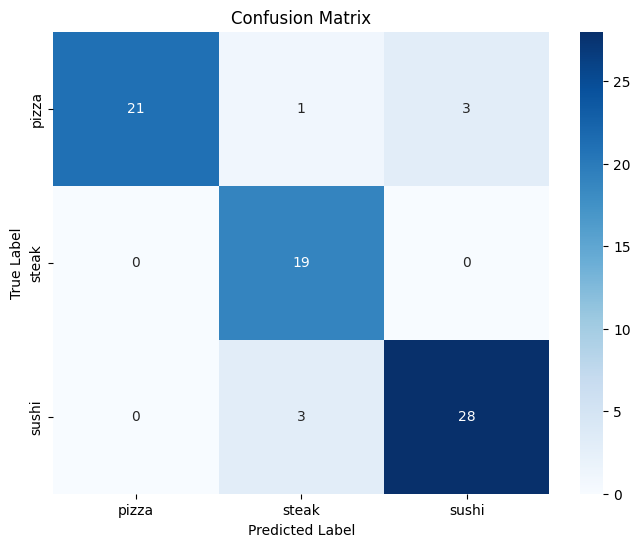

In [97]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_matrix = confmat(all_preds_tensor, all_labels_tensor)

df_cm = pd.DataFrame(conf_matrix.numpy(), 
                     index=class_names, 
                     columns=class_names)

plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [98]:
# TODO 
efficientnet_b2_weigths = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b2(weights=efficientnet_b2_weigths)

summarize_model(model=model_3)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\enesy/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:11<00:00, 3.14MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [99]:
for param in model_3.features.parameters():
    param.requires_grad = False

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.003)

train(model=model_3,
      train_dataloader=train_dataloader_20_percent,
      test_dataloader=test_dataloader_20_percent,
      optimizer=optimizer,
      loss_fn=criterion,
      epochs=10,
      device=device
      )



 10%|█         | 1/10 [00:14<02:10, 14.51s/it]

Epoch: 1 | train_loss: 3.6392 | train_acc: 0.2250 | test_loss: 1.9118 | test_acc: 0.4693


 20%|██        | 2/10 [00:30<02:02, 15.27s/it]

Epoch: 2 | train_loss: 1.2055 | train_acc: 0.5354 | test_loss: 0.8773 | test_acc: 0.6960


 30%|███       | 3/10 [00:48<01:55, 16.50s/it]

Epoch: 3 | train_loss: 0.7429 | train_acc: 0.7667 | test_loss: 0.6872 | test_acc: 0.7983


 40%|████      | 4/10 [01:05<01:40, 16.68s/it]

Epoch: 4 | train_loss: 0.5554 | train_acc: 0.8458 | test_loss: 0.6283 | test_acc: 0.8324


 50%|█████     | 5/10 [01:22<01:24, 16.96s/it]

Epoch: 5 | train_loss: 0.5104 | train_acc: 0.8438 | test_loss: 0.5646 | test_acc: 0.8330


 60%|██████    | 6/10 [01:40<01:09, 17.32s/it]

Epoch: 6 | train_loss: 0.4976 | train_acc: 0.8167 | test_loss: 0.5281 | test_acc: 0.8795


 70%|███████   | 7/10 [01:58<00:52, 17.54s/it]

Epoch: 7 | train_loss: 0.4003 | train_acc: 0.8646 | test_loss: 0.5654 | test_acc: 0.8636


 80%|████████  | 8/10 [02:16<00:35, 17.69s/it]

Epoch: 8 | train_loss: 0.3230 | train_acc: 0.9146 | test_loss: 0.4566 | test_acc: 0.8733


 90%|█████████ | 9/10 [02:35<00:17, 17.92s/it]

Epoch: 9 | train_loss: 0.2911 | train_acc: 0.9417 | test_loss: 0.4063 | test_acc: 0.8949


100%|██████████| 10/10 [02:53<00:00, 17.33s/it]

Epoch: 10 | train_loss: 0.3039 | train_acc: 0.9083 | test_loss: 0.4218 | test_acc: 0.8795


{'train_loss': [3.6392351468404134,
  1.2054959058761596,
  0.7428881088892619,
  0.5553997655709585,
  0.5104496121406555,
  0.4975617229938507,
  0.4002638354897499,
  0.3229948361714681,
  0.2910910209019979,
  0.30387738943099973],
 'train_acc': [0.225,
  0.5354166666666667,
  0.7666666666666667,
  0.8458333333333333,
  0.84375,
  0.8166666666666667,
  0.8645833333333334,
  0.9145833333333333,
  0.9416666666666667,
  0.9083333333333333],
 'test_loss': [1.9118156909942627,
  0.8772892236709595,
  0.6871907949447632,
  0.6283244490623474,
  0.5645588994026184,
  0.5280699253082275,
  0.5654376983642578,
  0.4566333591938019,
  0.40629866123199465,
  0.42179466485977174],
 'test_acc': [0.46931818181818186,
  0.6960227272727273,
  0.7982954545454545,
  0.8323863636363636,
  0.8329545454545455,
  0.8795454545454545,
  0.8636363636363636,
  0.8732954545454545,
  0.8948863636363636,
  0.8795454545454545]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


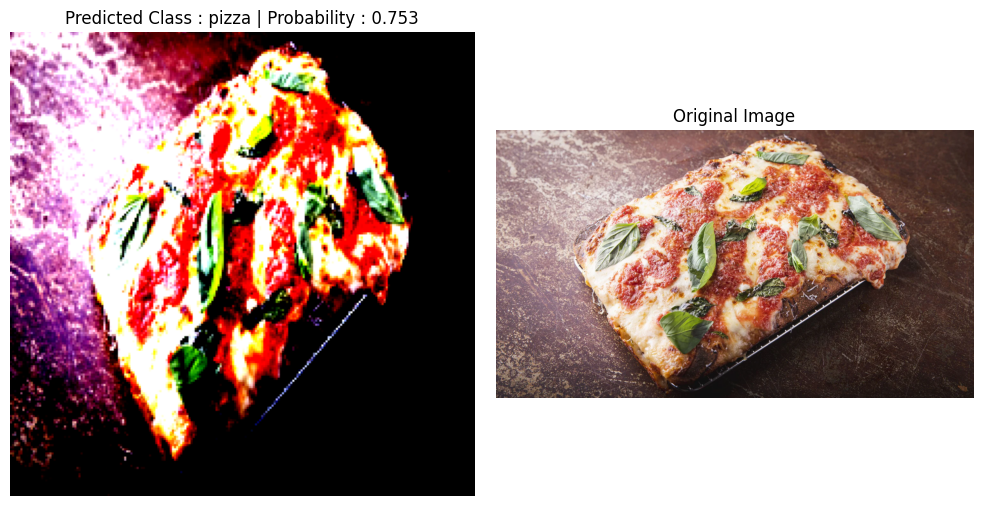

In [101]:
plot_my_own_img(img_path=data_path / "sicilian_pizza.jpg", model=model_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


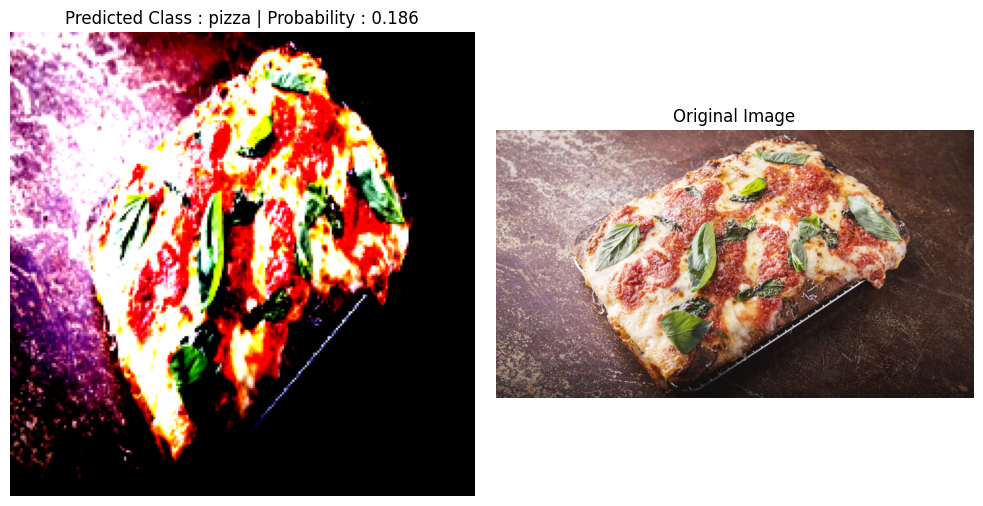

In [102]:
plot_my_own_img(img_path=data_path / "sicilian_pizza.jpg", model=model_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


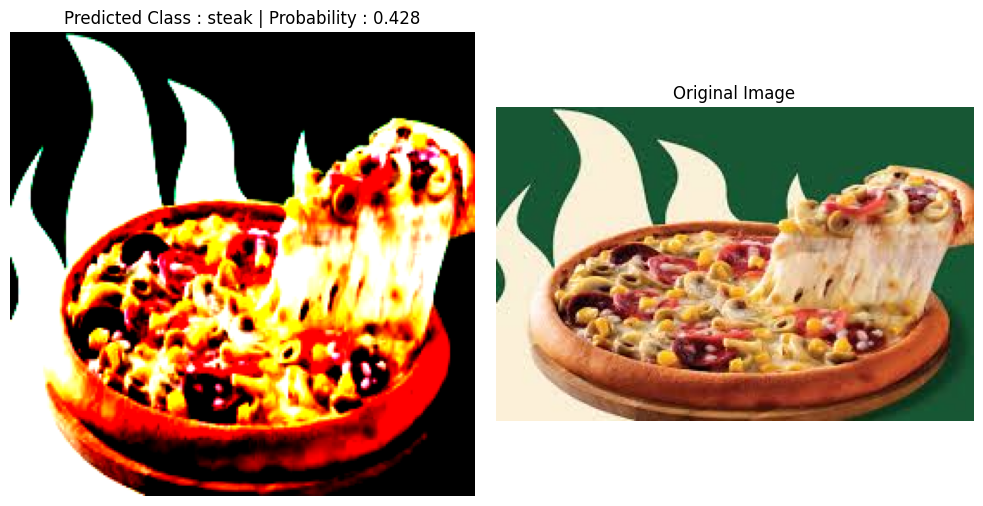

In [103]:
plot_my_own_img(data_path / "pizza2.jpg", model=model_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


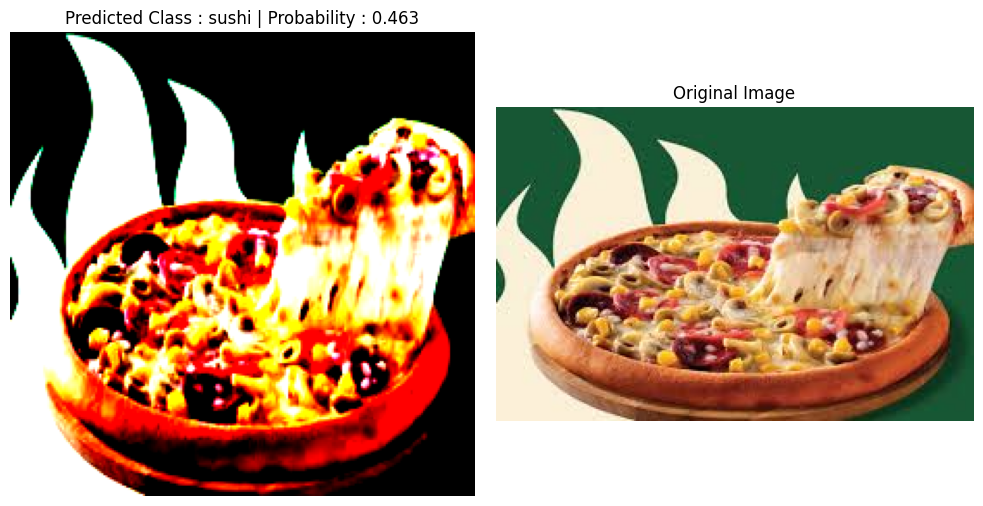

In [104]:
plot_my_own_img(data_path / "pizza2.jpg", model=model_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


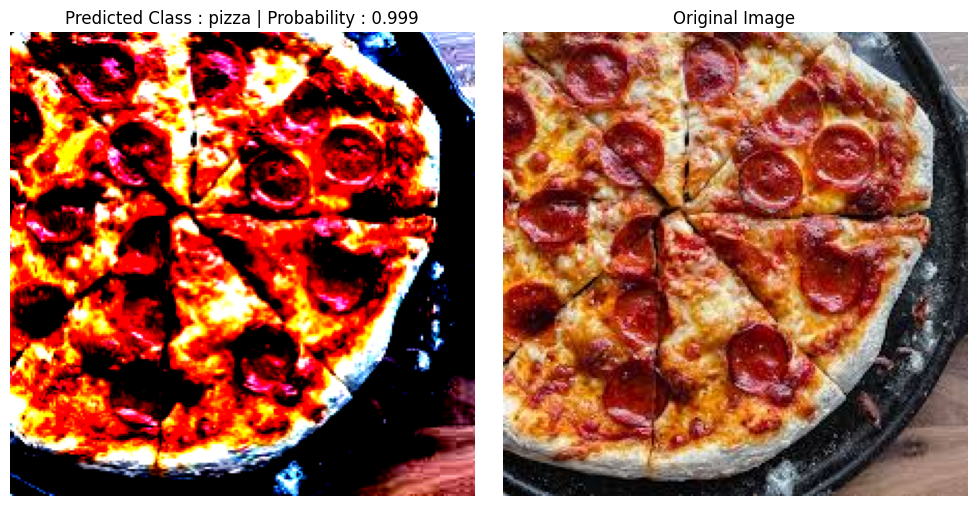

In [105]:
plot_my_own_img(data_path / "pizza3.jpg", model=model_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


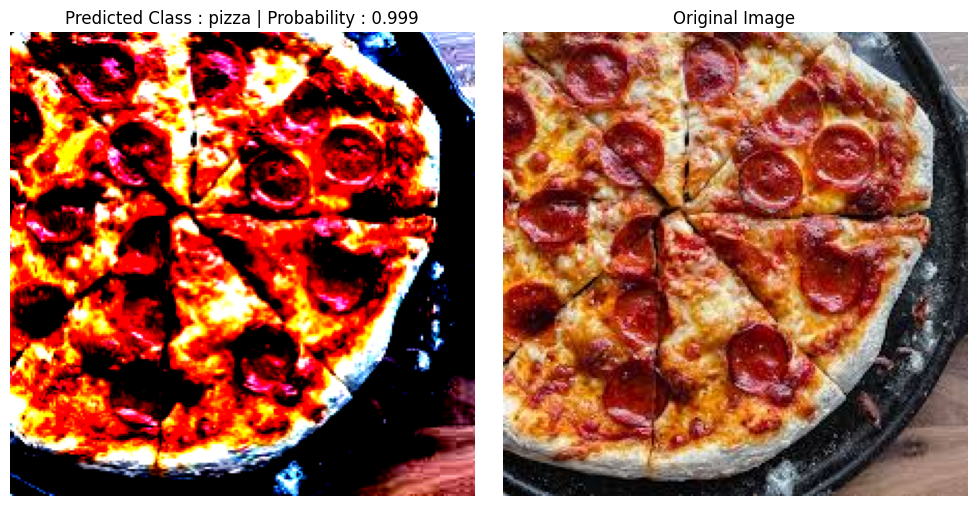

In [106]:
plot_my_own_img(data_path / "pizza3.jpg", model=model_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


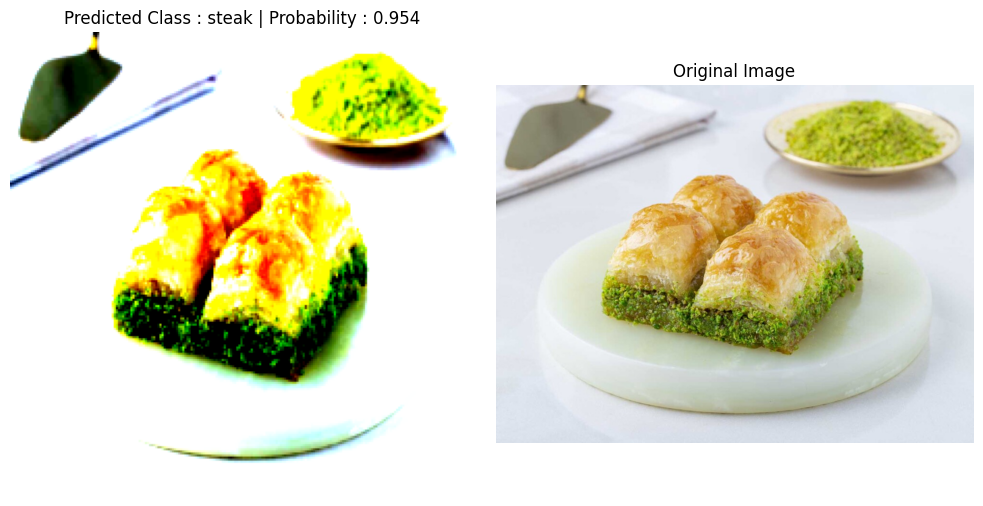

In [107]:
plot_my_own_img(data_path / "baklava.jpg", model=model_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


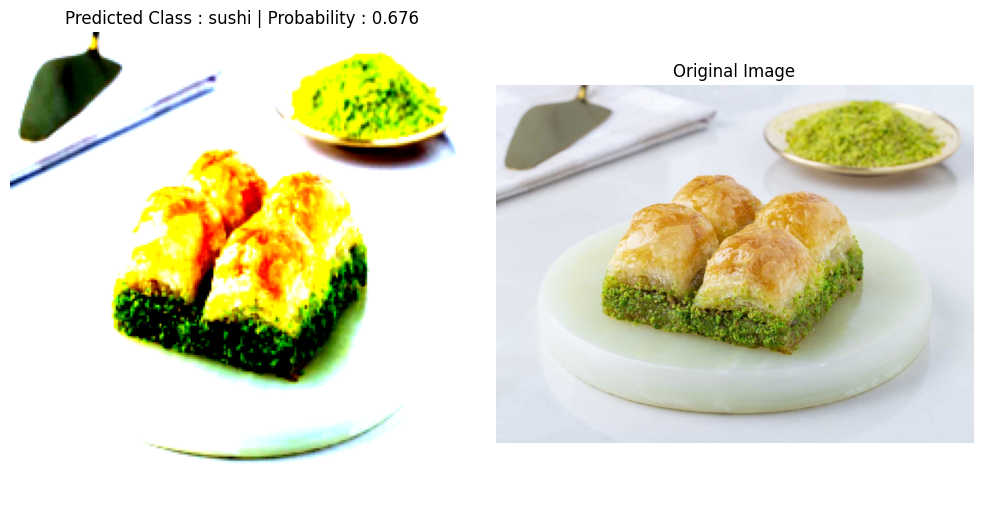

In [108]:
plot_my_own_img(data_path / "baklava.jpg", model=model_3)